In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [3]:
#from tensorflow.keras import models
#from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [4]:
df_input = pd.read_csv("CD3D_110℃_segment", usecols=[1,2,3,4,5])

In [5]:
df_output = pd. read_csv("CD3D_110℃_segment", usecols=[6])

In [6]:
df_input.shape

(422394, 5)

In [7]:
df_output.shape

(422394, 1)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.1, random_state=0)  #testとvalidとtrainにさらに分ける必要あり

In [9]:
print(x_train.shape,x_test.shape)

(380154, 5) (42240, 5)


In [10]:
x_train

,x座標,y座標,z座標,V[V],Segment
341905,0.000231,0.0163,0.001180,0.550,2.1
151133,0.000046,0.0145,0.001180,0.275,1.4
228959,0.000923,0.0075,0.001170,0.600,1.4
24384,0.001662,0.0073,0.001165,0.350,0.7
65056,0.001708,0.0057,0.001165,0.500,0.7
...,...,...,...,...,...
359783,0.000000,0.0221,0.001173,0.600,2.1
358083,0.000000,0.0161,0.001178,0.650,2.1
152315,0.000046,0.0130,0.001180,0.275,1.4
117952,0.001569,0.0000,0.001165,0.800,0.7


In [11]:
y_train

,i[A/m^2]
341905,469.630739
151133,892.617245
228959,397.248956
24384,776.272659
65056,545.922158
...,...
359783,395.606099
358083,324.610442
152315,892.907448
117952,130.088737


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers, initializers

model = Sequential()

weights = [com.get_weights() for com in model.layers[0:]]  #重さを抽出（※始めに回すときだけ下の行と入れ替える）



model.add(Dense(units=16, input_shape=(5,), activation='relu'))  
model.add(Dense(units=8, activation='relu'))  #
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='linear'))  #隠れ層3層でやってみる

model.compile(loss='mean_absolute_error',    
              optimizer='adam',             #とりあえずadamで
              metrics=['mae'],
              run_eagerly=False)   #計算時間5倍くらいかかる

In [13]:
callbacks1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae',
                            factor=0.2,
                            patience=5,
                            mode="auto",
                            min_lr=0.001)
callbacks2 = tf.keras.callbacks.EarlyStopping(monitor="val_mae",
                                              patience=20,
                                              mode="auto")
history =  model.fit(x=x_train,
                     y=y_train,
                     epochs = 20000,
                     batch_size=200,
                     validation_data=(x_test, y_test),
                     callbacks=[callbacks1,callbacks2])

Epoch 1/20000
1901/1901 [==============================] - 4s 2ms/step - loss: 291.7154 - mae: 291.7154 - val_loss: 32.3383 - val_mae: 32.3383 - lr: 0.0010
Epoch 2/20000
1901/1901 [==============================] - 3s 1ms/step - loss: 8.9541 - mae: 8.9541 - val_loss: 6.4785 - val_mae: 6.4785 - lr: 0.0010
Epoch 3/20000
1901/1901 [==============================] - 3s 1ms/step - loss: 6.2032 - mae: 6.2032 - val_loss: 6.1523 - val_mae: 6.1523 - lr: 0.0010
Epoch 4/20000
1901/1901 [==============================] - 3s 1ms/step - loss: 5.9290 - mae: 5.9290 - val_loss: 5.9255 - val_mae: 5.9255 - lr: 0.0010
Epoch 5/20000
1901/1901 [==============================] - 3s 1ms/step - loss: 5.7422 - mae: 5.7422 - val_loss: 5.8198 - val_mae: 5.8198 - lr: 0.0010
Epoch 6/20000
1901/1901 [==============================] - 3s 1ms/step - loss: 5.6280 - mae: 5.6280 - val_loss: 5.6729 - val_mae: 5.6729 - lr: 0.0010
Epoch 7/20000
1901/1901 [==============================] - 3s 2ms/step - loss: 5.5294 - mae: 5

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])

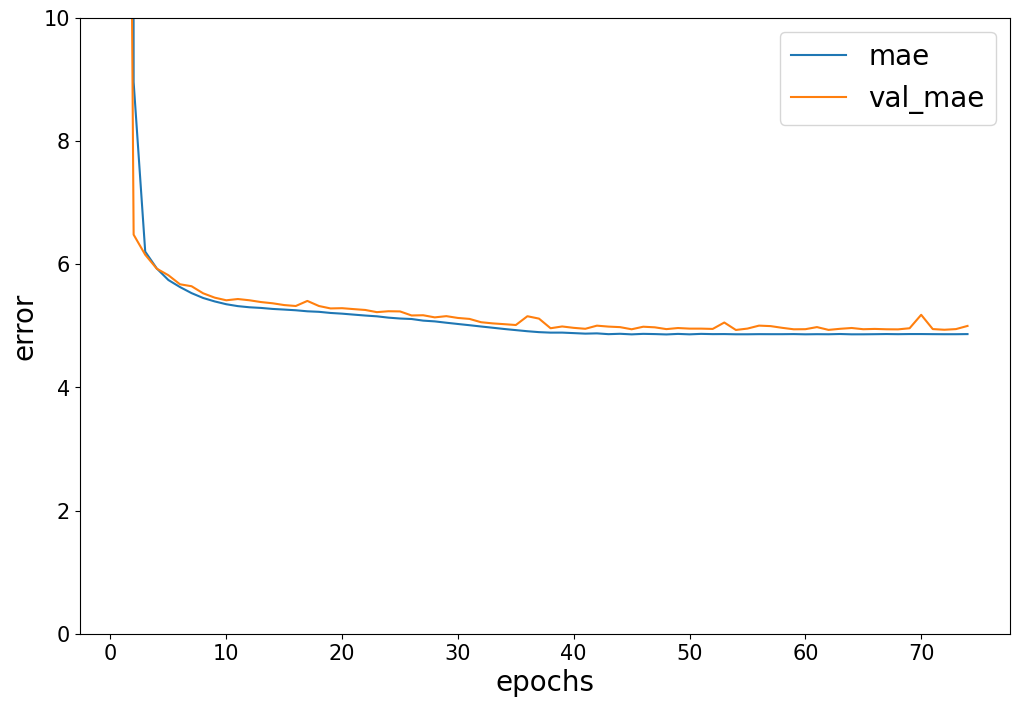

In [20]:
mae = history_dict['mae']
val_mse = history_dict['val_mae']
epochs = range(1, len(mae) + 1)

plt.rcParams["font.size"] = 15
plt.figure(figsize=(12, 8))
plt.plot(epochs, mae, label='mae')
plt.plot(epochs, val_mse, label='val_mae')
plt.xlabel("epochs",fontsize=20)
plt.ylabel("error",fontsize=20)
plt.ylim((0,10))
plt.legend(loc = 'best',fontsize=20)
#plt.savefig('mae_transition.png')
plt.show()

In [16]:
import tensorflow as tf

# MAPEを計算する関数を定義
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # ゼロで割ることを避けるための小さな値
    percentage_error = tf.abs((y_true - y_pred) / (tf.maximum(tf.abs(y_true), epsilon)))
    mape = tf.reduce_mean(percentage_error) * 100.0
    return mape

df7 = model.predict(df_input)
# MAPEを計算
df7 = pd.DataFrame(df7)
df8 = pd.concat([pd.DataFrame(df_output),df7], axis=1)

y_true = tf.constant(df8.iloc[:, 0].values, dtype=tf.float32)
y_pred = tf.constant(df8.iloc[:, 1].values, dtype=tf.float32)
mape_value = mean_absolute_percentage_error(y_true,y_pred)

# 結果を表示
print(f"MAPE: {mape_value.numpy()}%")

13200/13200 [==============================] - 8s 604us/step
MAPE: 46.114471435546875%


In [17]:
weights = [com.get_weights() for com in model.layers[0:]] 
model.layers[0].set_weights(weights[0])
model.layers[1].set_weights(weights[1])
model.layers[2].set_weights(weights[2])

In [18]:
model.save('i_predict CD_segment')

INFO:tensorflow:Assets written to: i_predict CD_segment\assets
